In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="4"

device = 'cuda:0'

Mon Jan 15 17:25:47 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   26C    P8    17W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 44%   

### Dataset

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

### Preprocess
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

# Create data loaders
# train_loader = DataLoader(mnist_trainset, batch_size=60000, shuffle=False)
# batch = next(iter(train_loader))
# data = preprocess(batch)
# print(data.keys())

test_loader = DataLoader(mnist_testset, batch_size=10000, shuffle=False)
batch = next(iter(test_loader))
data = preprocess(batch)
print(data.keys())

dict_keys(['x', 't'])


### Model Parts

In [5]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_vae_encoder import Encoder
from model.latent_layer.vae_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [6]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [7]:
model_list = []
for i in range(10):
    model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
    model = model.to(device)
    model.eval()
    model_list.append(model)
    
print('done')

done


### Load

In [8]:
!ls -lt /data/scpark/save/lse/train01.14-8/

total 8561844
-rw-rw-r-- 1 scpark scpark  20534892  1월 15 16:15 events.out.tfevents.1705239792.GPUSVR01
-rw-rw-r-- 1 scpark scpark 380294645  1월 15 16:05 save_210000
-rw-rw-r-- 1 scpark scpark 380294645  1월 15 15:17 save_200000
-rw-rw-r-- 1 scpark scpark 380294645  1월 15 14:28 save_190000
-rw-rw-r-- 1 scpark scpark 380294645  1월 15 13:39 save_180000
-rw-rw-r-- 1 scpark scpark 380294645  1월 15 12:49 save_170000
-rw-rw-r-- 1 scpark scpark 380294645  1월 15 11:59 save_160000
-rw-rw-r-- 1 scpark scpark 380294645  1월 15 11:09 save_150000
-rw-rw-r-- 1 scpark scpark 380294645  1월 15 10:19 save_140000
-rw-rw-r-- 1 scpark scpark 380294645  1월 15 09:30 save_130000
-rw-rw-r-- 1 scpark scpark 380294645  1월 15 08:40 save_120000
-rw-rw-r-- 1 scpark scpark 380294645  1월 15 07:50 save_110000
-rw-rw-r-- 1 scpark scpark 380294645  1월 15 07:00 save_100000
-rw-rw-r-- 1 scpark scpark 380292503  1월 15 06:10 save_90000
-rw-rw-r-- 1 scpark scpark 380292503  1월 15 05:20 save_80000
-rw-rw-r-- 1 scpark scpark 380

In [9]:
from tqdm import tqdm_notebook as tqdm

save_path = '/data/scpark/save/lse/train01.14-8/save_200000'

# warm start
models_state_dict = torch.load(save_path, map_location=torch.device('cpu'))['models_state_dict']
for i, model in tqdm(enumerate(model_list)):
    model.load_state_dict(models_state_dict[i], strict=True)

0it [00:00, ?it/s]

### Reconstruction Loss

#### partial

In [9]:
N = 10000

z_list = []
recon_loss_list = []
for model in tqdm(model_list):
    with torch.no_grad():
        zs = []
        recon_losses = []
        for i in range(0, len(data['x']), N):
            result = {'x': data['x'][i:i+N]}
            result = model(result, M=1)
            zs.append(result['z'])
            recon_losses.append(result['recon_loss'].item())
            
        z_list.append(torch.cat(zs, dim=0))
        recon_loss_list.append(np.mean(recon_losses))
        
print('Reconstruction Loss :', np.mean(recon_loss_list))

  0%|          | 0/10 [00:00<?, ?it/s]

Reconstruction Loss : 0.07966390450795492


#### All

In [10]:
z_list = []
recon_loss_list = []
for model in tqdm(model_list):
    with torch.no_grad():
        data = model(data, M=1)
        z_list.append(data['z'])
        recon_loss_list.append(data['recon_loss'].item())
        
print('Reconstruction Loss :', np.mean(recon_loss_list))

  0%|          | 0/10 [00:00<?, ?it/s]

Reconstruction Loss : 0.11973129510879517


### Linear Classification Test

In [16]:
def get_linear_classification_test(z, t, n_steps=100000):
    from model.classifier.linear_classifier import Classifier
    accuracy_list = []
    classifier = Classifier(2, 10)
    classifier = classifier.to(device)
    classifier.train()
    optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3)
    
    data = {'z': z, 't': t}
    for _ in tqdm(range(n_steps)):
        data = classifier(data)
        loss = data['cross_entropy_loss']
        loss.backward()
        optimizer.step()
        accuracy_list.append(data['accuracy'].item())
    return accuracy_list

print('done')

done


  0%|          | 0/100000 [00:00<?, ?it/s]

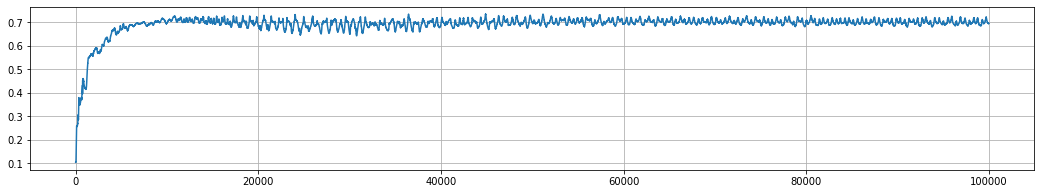

  0%|          | 0/100000 [00:00<?, ?it/s]

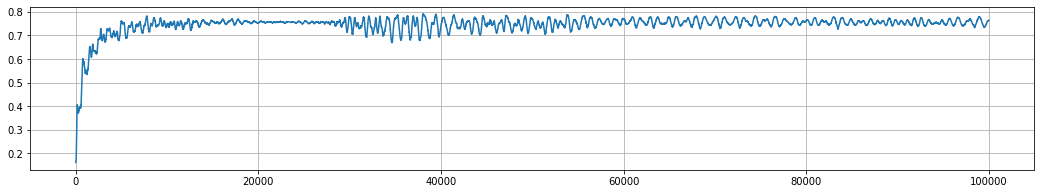

  0%|          | 0/100000 [00:00<?, ?it/s]

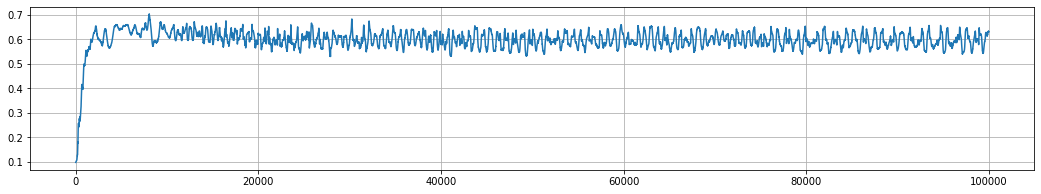

  0%|          | 0/100000 [00:00<?, ?it/s]

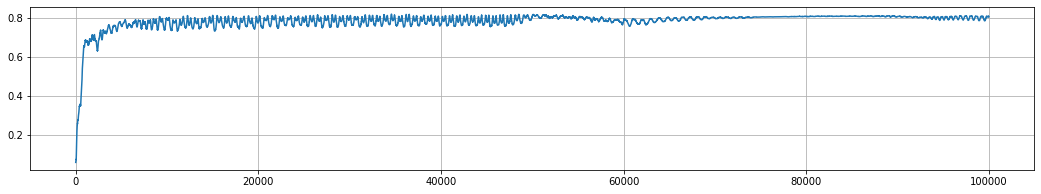

  0%|          | 0/100000 [00:00<?, ?it/s]

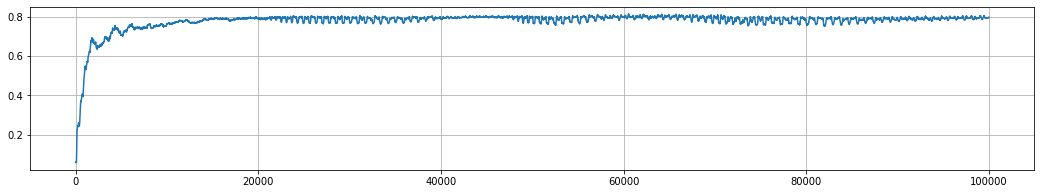

  0%|          | 0/100000 [00:00<?, ?it/s]

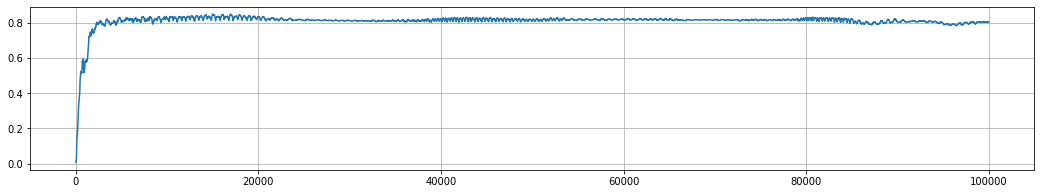

  0%|          | 0/100000 [00:00<?, ?it/s]

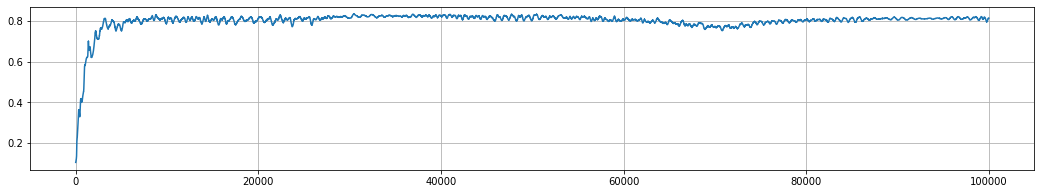

  0%|          | 0/100000 [00:00<?, ?it/s]

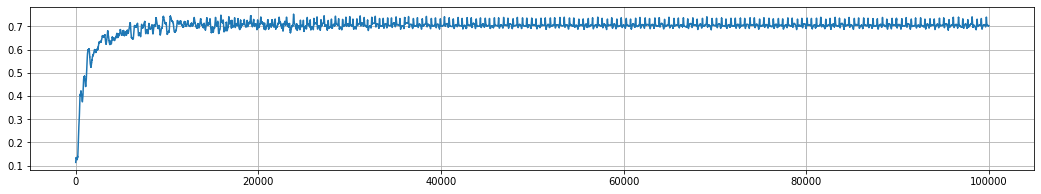

  0%|          | 0/100000 [00:00<?, ?it/s]

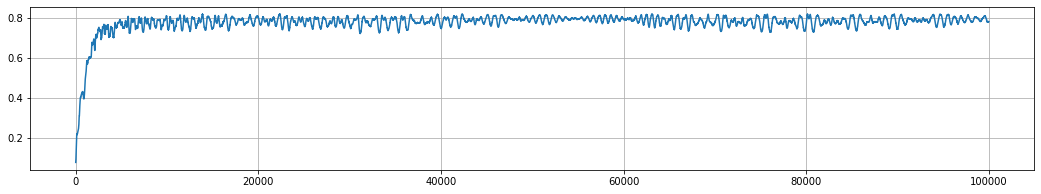

  0%|          | 0/100000 [00:00<?, ?it/s]

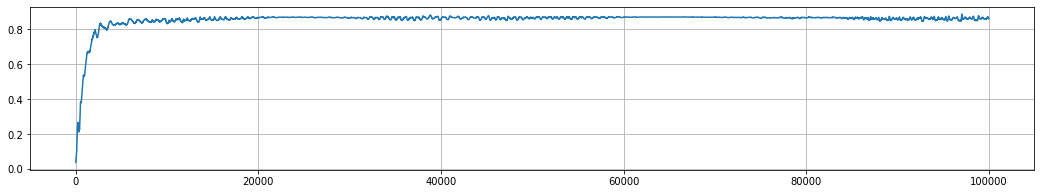

Accuracy : 0.7651199877262116


In [17]:
import matplotlib.pyplot as plt

accuracys = []
for z in z_list:
    accuracy_list = get_linear_classification_test(z, data['t'])
    accuracys.append(accuracy_list[-1])
    plt.figure(figsize=[18, 3])
    plt.plot(accuracy_list)
    plt.grid()
    plt.show()
    
print('Accuracy :', np.mean(accuracys))

### Two-Linear Classification Test

In [11]:
def get_two_linear_classification_test(z, t, n_steps=100000):
    from model.classifier.two_linear_classifier import Classifier
    accuracy_list = []
    classifier = Classifier(2, 512, 10)
    classifier = classifier.to(device)
    classifier.train()
    optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3)
    
    data = {'z': z, 't': t}
    for _ in tqdm(range(n_steps)):
        data = classifier(data)
        loss = data['cross_entropy_loss']
        loss.backward()
        optimizer.step()
        accuracy_list.append(data['accuracy'].item())
    return accuracy_list

print('done')

done


  0%|          | 0/100000 [00:00<?, ?it/s]

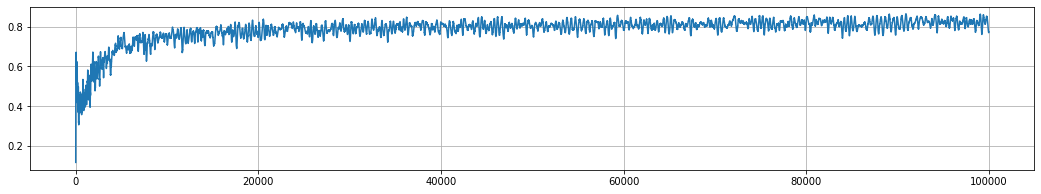

  0%|          | 0/100000 [00:00<?, ?it/s]

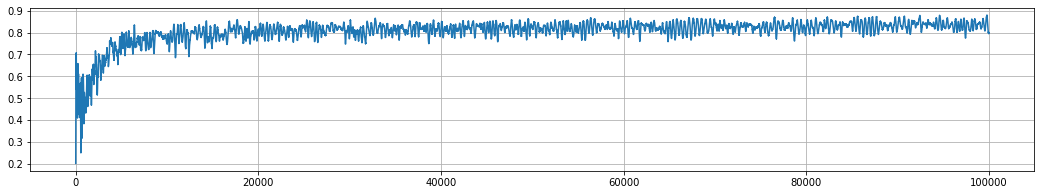

  0%|          | 0/100000 [00:00<?, ?it/s]

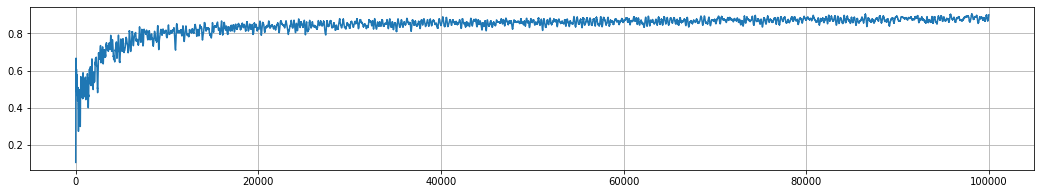

  0%|          | 0/100000 [00:00<?, ?it/s]

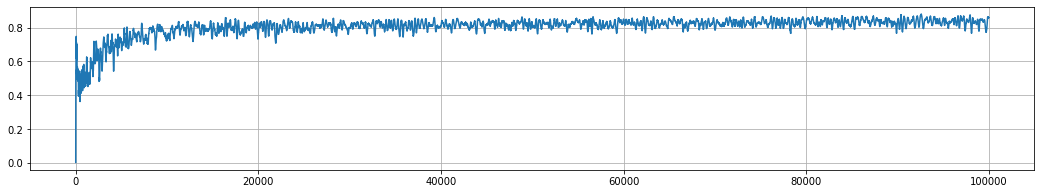

  0%|          | 0/100000 [00:00<?, ?it/s]

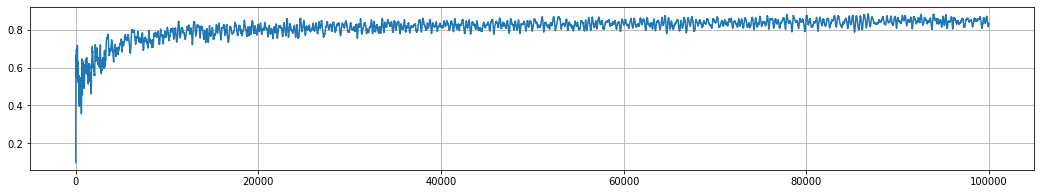

  0%|          | 0/100000 [00:00<?, ?it/s]

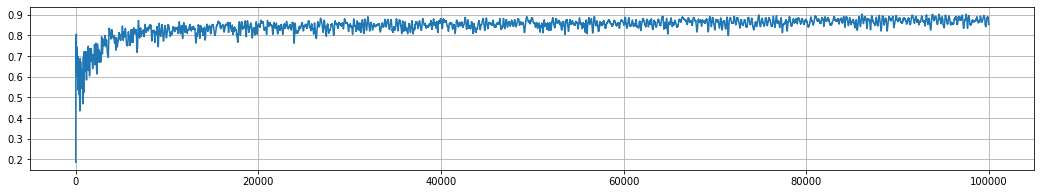

  0%|          | 0/100000 [00:00<?, ?it/s]

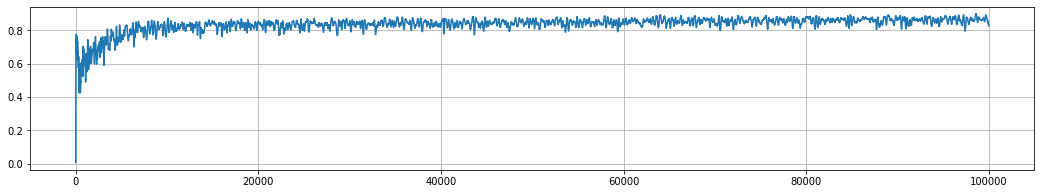

  0%|          | 0/100000 [00:00<?, ?it/s]

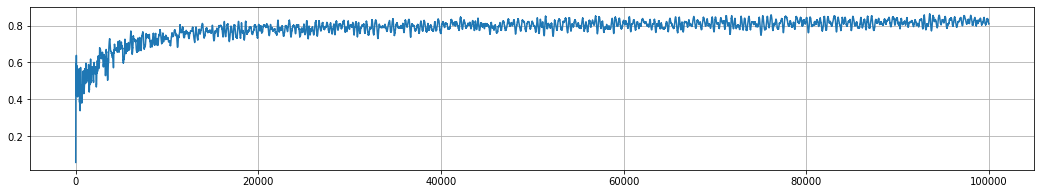

  0%|          | 0/100000 [00:00<?, ?it/s]

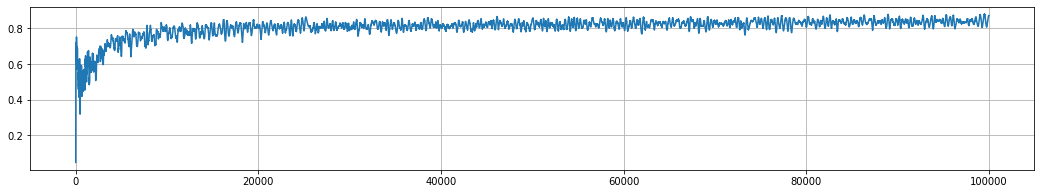

  0%|          | 0/100000 [00:00<?, ?it/s]

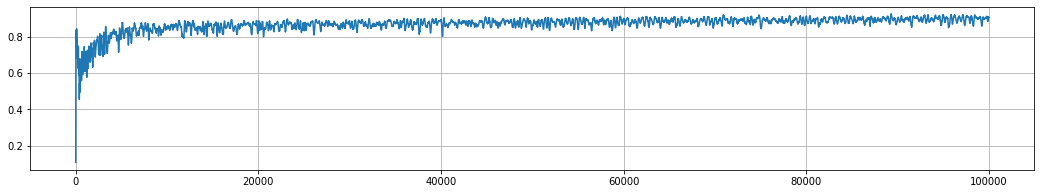

Accuracy : 0.8430399775505066


In [12]:
import matplotlib.pyplot as plt

accuracys = []
for z in z_list:
    accuracy_list = get_two_linear_classification_test(z, data['t'])
    accuracys.append(accuracy_list[-1])
    plt.figure(figsize=[18, 3])
    plt.plot(accuracy_list)
    plt.grid()
    plt.show()
    
print('Accuracy :', np.mean(accuracys))

### Silhouette Score Test

In [11]:
from sklearn.metrics import silhouette_score

scores = []
for z in tqdm(z_list):
    _z = z.data.cpu().numpy()
    _t = data['t'].data.cpu().numpy()
    score = silhouette_score(_z, _t)
    scores.append(score)
    
print('Silhouette Score :', np.mean(scores))

  0%|          | 0/10 [00:00<?, ?it/s]

Silhouette Score : 0.17417882


### MMD Test

In [13]:
from test_util.mmd_loss import MMDLoss

mmd_losses = []
mmd = MMDLoss()
for z in tqdm(z_list):
    prior = torch.randn_like(z)
    mmd_loss = mmd(prior.to('cpu'), z.to('cpu'))
    mmd_losses.append(mmd_loss.item())
    
print('MMD Loss :', np.mean(mmd_losses))    

  0%|          | 0/10 [00:00<?, ?it/s]

MMD Loss : 0.026791715621948244


In [14]:
mmd_losses

[0.039788007736206055,
 0.02682971954345703,
 0.04428839683532715,
 0.02732229232788086,
 0.030571699142456055,
 0.014168977737426758,
 0.012796640396118164,
 0.033411264419555664,
 0.02399444580078125,
 0.014745712280273438]

### View Embeddings

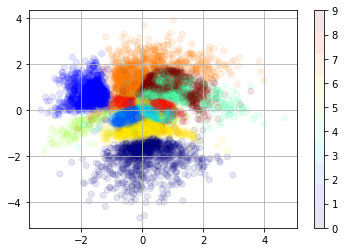

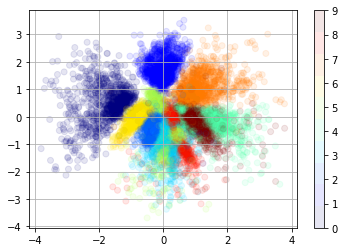

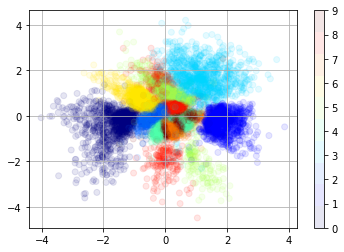

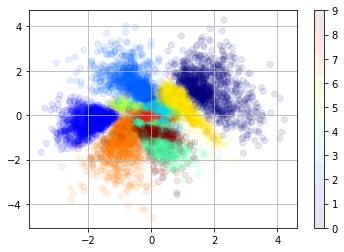

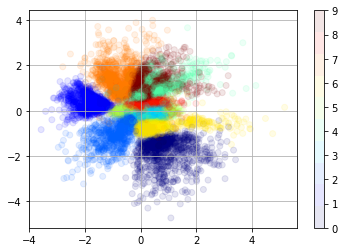

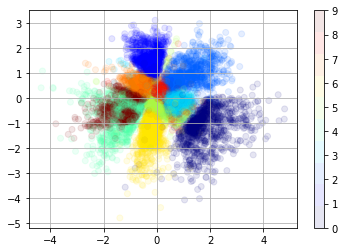

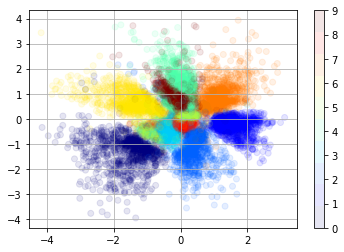

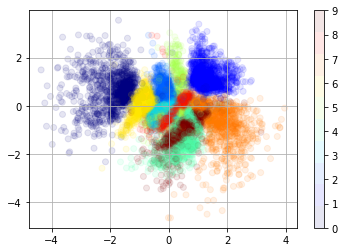

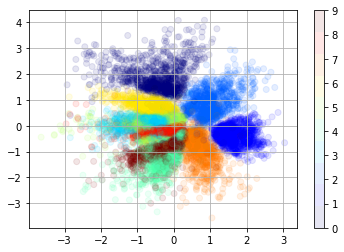

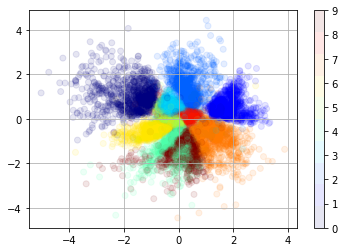

In [15]:
import matplotlib.pyplot as plt

# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


for z in z_list:
    _z = z.data.cpu().numpy()
    plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'), alpha=0.1)
    plt.grid()
    plt.colorbar()
    plt.show()